In [1]:
# Cell 1: ライブラリのインポートとモデル定義
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# PyTorchの警告を無視 (開発時は非推奨ですが、Notebookでの実行をスムーズにするため)
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/models")
from Binary_classification import Binary_classification as model

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


In [2]:
temp_model = model(latent=100, input_depth=30, input_height=100, input_width=100) 
dummy_input = torch.randn(1, 1, 30, 100, 100) 

# 特徴抽出層まで実行
output_features = temp_model.features(dummy_input)

# 結果のサイズを確認
print(output_features.size())

torch.Size([1, 16, 1, 10, 10])


In [3]:
class DataSet:
    def __init__(self, data, label):
        self.label = label
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, path, patience=10, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # self.flog.write(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    
    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
            # self.flog.write(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
bubble_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/slide_bubble.npy")
removal_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/all_data_after_bubble_removal.npy")

# バブルのラベルは1、非バブルのラベルは0
bubble_label = [1] * len(bubble_data)
removal_label = [0] * len(removal_data)

In [6]:
# print(len(bubble_data))
# print(len(removal_data))
# print(bubble_label)
# print(removal_label)

In [7]:
data = np.concatenate((bubble_data, removal_data))
label = np.concatenate((bubble_label, removal_label))

In [8]:
len(data)

5659

In [9]:
# data = torch.from_numpy(data).float()
train_data, val_data, train_labels, val_labels = train_test_split(
    data, label, test_size=0.2, random_state=42, stratify=label
)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels
)

# train_data = augment_data(train_data, augment_horizontal, augment_vertical, augment_velocity_axis)
# train_labels     = [0] * len(train_data)

train_dataset    = DataSet(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset      = DataSet(val_data, val_labels)
val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloader_dic   = {"train": train_dataloader, "val": val_dataloader}


# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# dataloader_dic = {"train": train_dataloader, "val": val_dataloader}

In [10]:
print(849//16)
print(849%16)

53
1


In [11]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4527
849
283


In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [13]:
model = model(latent=100, input_depth=30, input_height=100, input_width=100)
model.apply(weights_init)
model.to(device)

Binary_classification(
  (features): Sequential(
    (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (11): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (

In [14]:
optimizer = optim.AdamW(
        model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False
    )
criterion = nn.BCELoss()

In [15]:
early_stopping = EarlyStopping(patience=20, verbose=True, path="/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/save_dir/model_parameter.pth")

In [20]:
train_loss_list = []

val_loss_list = []
val_accuracy_list = []
val_recall_list = []

best_val_loss = float('inf')
start = time.time()
num_epochs = 1000


for epoch in range(num_epochs):
    train_loss_num = 0
    val_loss_num = 0

    # 精度計算のためのカウンター
    val_correct_preds = 0
    val_total_samples = 0

    val_true_positives = 0
    val_actual_positives = 0 # (TP + FN)

    for phase in ["train", "val"]:
        dataloader = dataloader_dic[phase]
        if phase == "train":
            model.train()  # モデルを訓練モードに
        else:
            model.eval()

        for images, labels in tqdm(dataloader):
            images = images.view(-1, 1, 30, 100, 100)
            labels = labels.to(device).float().unsqueeze(1)
            # print(labels)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):

                # モデルの出力を計算する
                output, latent = model(images.clone().float().to(device))
                # print(output)
                # print(labels)
                # 損失を計算する
                loss = criterion(output.to("cpu"), labels.to("cpu"))
                weighted_loss = torch.mean(loss)

                if phase == "val":
                    # Sigmoid出力 (output) を使用し、0.5を閾値として予測
                    # outputは [B, 1]、labels_deviceは [B, 1]
                    predicted = (output > 0.5).float()
                    
                    # 1. 精度 (Accuracy) の計算
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)
                    
                    # 2. Recallの計算
                    # a. True Positives (TP): predicted=1 かつ actual=1
                    val_true_positives += ((predicted == 1) & (labels == 1)).sum().item()
                    
                    # b. Actual Positives (TP + FN): actual=1 (正解ラベルが1の総数)
                    val_actual_positives += (labels == 1).sum().item()
                
                # パラメータの更新
                if phase == "train":
                    weighted_loss.backward()
                    optimizer.step()
                    train_loss_num += weighted_loss.item()
                else:
                    val_loss_num += weighted_loss.item()
                    
        # エポック終了後の検証精度の計算
        val_accuracy = val_correct_preds / val_total_samples if val_total_samples > 0 else 0.0
        
        # ⭐ 検証再現率 (Recall) の計算 ⭐
        val_recall = val_true_positives / val_actual_positives if val_actual_positives > 0 else 0.0
        
        if phase == "train":
            train_loss_list.append(train_loss_num)
        else:
            val_loss_list.append(val_loss_num)
            val_accuracy_list.append(val_accuracy)
            val_recall_list.append(val_recall)
            
    # wandb.log({"train loss": train_loss_num, "validation loss": val_loss_num, "epoch":  epoch})
    # if val_loss_num < best_val_loss:
    #     best_val_loss = val_loss_num
        # wandb.log({"best validation loss": best_val_loss, "epoch":  epoch})
    
    # print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, val_loss_num))
    print("Epoch [{}/{}], Val Loss: {:.4f}, Val Accuracy: {:.4f}, Val Recall: {:.4f}".format(
        epoch + 1, num_epochs, val_loss_num, val_accuracy, val_recall # Recallを追加
    ))
    
    early_stopping(val_loss_num, model)
    if early_stopping.early_stop:
        print("Early_Stopping")
        break
    print("")
    
#train_loss_path = args.savedir_path + "/loss_log" + f"/train_loss_{args.wandb_name}.npy"
#val_loss_path = args.savedir_path + "/loss_log" + f"/val_loss_{args.wandb_name}.npy"

#np.save(train_loss_path, train_loss_list)
#np.save(val_loss_path, val_loss_list)

print((time.time() - start) / 60)

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1/1000], Val Loss: 1.0168, Val Accuracy: 0.9953, Val Recall: 0.9286
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2/1000], Val Loss: 0.3090, Val Accuracy: 0.9976, Val Recall: 0.9524
Validation loss decreased (0.312942 --> 0.309048).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3/1000], Val Loss: 0.8918, Val Accuracy: 0.9976, Val Recall: 0.9524
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4/1000], Val Loss: 0.5745, Val Accuracy: 0.9965, Val Recall: 0.9286
EarlyStopping counter: 2 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5/1000], Val Loss: 0.4999, Val Accuracy: 0.9965, Val Recall: 0.9524
EarlyStopping counter: 3 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6/1000], Val Loss: 0.2155, Val Accuracy: 0.9988, Val Recall: 0.9762
Validation loss decreased (0.309048 --> 0.215459).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7/1000], Val Loss: 0.5078, Val Accuracy: 0.9965, Val Recall: 0.9524
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8/1000], Val Loss: 0.1670, Val Accuracy: 0.9988, Val Recall: 0.9762
Validation loss decreased (0.215459 --> 0.167018).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9/1000], Val Loss: 0.5264, Val Accuracy: 0.9976, Val Recall: 0.9524
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [10/1000], Val Loss: 0.8630, Val Accuracy: 0.9941, Val Recall: 0.8810
EarlyStopping counter: 2 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [11/1000], Val Loss: 0.4347, Val Accuracy: 0.9976, Val Recall: 0.9524
EarlyStopping counter: 3 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [12/1000], Val Loss: 0.3759, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 4 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [13/1000], Val Loss: 0.4277, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 5 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [14/1000], Val Loss: 0.3479, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 6 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [15/1000], Val Loss: 0.3466, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 7 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [16/1000], Val Loss: 0.3210, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 8 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [17/1000], Val Loss: 0.0665, Val Accuracy: 1.0000, Val Recall: 1.0000
Validation loss decreased (0.167018 --> 0.066451).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [18/1000], Val Loss: 0.1332, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [19/1000], Val Loss: 0.2074, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 2 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [20/1000], Val Loss: 0.5621, Val Accuracy: 0.9965, Val Recall: 0.9286
EarlyStopping counter: 3 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [21/1000], Val Loss: 0.2063, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 4 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [22/1000], Val Loss: 0.7698, Val Accuracy: 0.9965, Val Recall: 0.9524
EarlyStopping counter: 5 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [23/1000], Val Loss: 0.2544, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 6 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [24/1000], Val Loss: 0.3620, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 7 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [25/1000], Val Loss: 0.2140, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 8 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [26/1000], Val Loss: 0.3080, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 9 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [27/1000], Val Loss: 0.2426, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 10 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [28/1000], Val Loss: 0.1986, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 11 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [29/1000], Val Loss: 1.2282, Val Accuracy: 0.9965, Val Recall: 1.0000
EarlyStopping counter: 12 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [30/1000], Val Loss: 0.7580, Val Accuracy: 0.9976, Val Recall: 0.9524
EarlyStopping counter: 13 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [31/1000], Val Loss: 0.2911, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 14 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [32/1000], Val Loss: 0.8992, Val Accuracy: 0.9953, Val Recall: 0.9048
EarlyStopping counter: 15 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [33/1000], Val Loss: 0.0862, Val Accuracy: 1.0000, Val Recall: 1.0000
EarlyStopping counter: 16 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [34/1000], Val Loss: 0.0296, Val Accuracy: 1.0000, Val Recall: 1.0000
Validation loss decreased (0.066451 --> 0.029649).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [35/1000], Val Loss: 0.0158, Val Accuracy: 1.0000, Val Recall: 1.0000
Validation loss decreased (0.029649 --> 0.015812).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [36/1000], Val Loss: 0.0198, Val Accuracy: 1.0000, Val Recall: 1.0000
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [37/1000], Val Loss: 0.0136, Val Accuracy: 1.0000, Val Recall: 1.0000
Validation loss decreased (0.015812 --> 0.013573).  Saving model ...



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [38/1000], Val Loss: 4.1099, Val Accuracy: 0.9835, Val Recall: 0.6667
EarlyStopping counter: 1 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [39/1000], Val Loss: 0.6384, Val Accuracy: 0.9941, Val Recall: 0.8810
EarlyStopping counter: 2 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [40/1000], Val Loss: 0.1114, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 3 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [41/1000], Val Loss: 0.2559, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 4 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [42/1000], Val Loss: 0.4779, Val Accuracy: 0.9953, Val Recall: 0.9286
EarlyStopping counter: 5 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [43/1000], Val Loss: 0.3116, Val Accuracy: 0.9976, Val Recall: 0.9762
EarlyStopping counter: 6 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [44/1000], Val Loss: 0.6099, Val Accuracy: 0.9965, Val Recall: 0.9286
EarlyStopping counter: 7 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [45/1000], Val Loss: 0.3368, Val Accuracy: 0.9976, Val Recall: 0.9762
EarlyStopping counter: 8 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [46/1000], Val Loss: 0.2958, Val Accuracy: 0.9976, Val Recall: 0.9524
EarlyStopping counter: 9 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [47/1000], Val Loss: 0.2165, Val Accuracy: 0.9976, Val Recall: 0.9762
EarlyStopping counter: 10 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [48/1000], Val Loss: 3.2629, Val Accuracy: 0.9753, Val Recall: 0.9048
EarlyStopping counter: 11 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [49/1000], Val Loss: 0.0581, Val Accuracy: 1.0000, Val Recall: 1.0000
EarlyStopping counter: 12 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [50/1000], Val Loss: 0.0904, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 13 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [51/1000], Val Loss: 0.0401, Val Accuracy: 1.0000, Val Recall: 1.0000
EarlyStopping counter: 14 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [52/1000], Val Loss: 0.0216, Val Accuracy: 1.0000, Val Recall: 1.0000
EarlyStopping counter: 15 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [53/1000], Val Loss: 0.1168, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 16 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [54/1000], Val Loss: 0.1024, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 17 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [55/1000], Val Loss: 0.0774, Val Accuracy: 0.9988, Val Recall: 0.9762
EarlyStopping counter: 18 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [56/1000], Val Loss: 0.4247, Val Accuracy: 0.9976, Val Recall: 0.9762
EarlyStopping counter: 19 out of 20



  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [57/1000], Val Loss: 2.0361, Val Accuracy: 0.9882, Val Recall: 0.9762
EarlyStopping counter: 20 out of 20
Early_Stopping
4.015937805175781


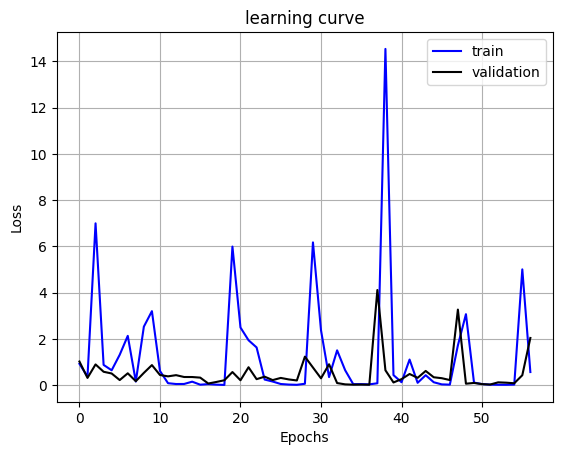

In [21]:
plt.plot(range(len(train_loss_list)), train_loss_list, "b", label="train")
plt.plot(range(len(val_loss_list)), val_loss_list, "k", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("learning curve")
plt.legend()
plt.grid()
# plt.savefig("Add_MaxPlool.png")
plt.show()

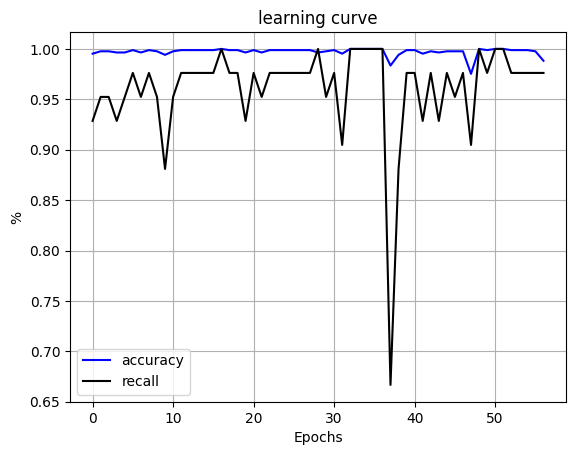

In [22]:
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, "b", label="accuracy")
plt.plot(range(len(val_recall_list)), val_recall_list, "k", label="recall")
plt.xlabel("Epochs")
plt.ylabel("%")
plt.title("learning curve")
plt.legend()
plt.grid()
# plt.savefig("Add_MaxPool_acurracy.png")
plt.show()

In [ ]:
import math
print(math.log(0.98))